**Name:** Muluwork Geremew 

**Course:** Advanced Big Data and Data Mining  
**Project:** Advanced Data Mining for Data-Driven Insights and Predictive Modeling (Deliverbale 1)

## 🔹 Plan for Deliverable 3

In Deliverable 3, the goal is to extend analysis beyond regression to classification, clustering, and pattern mining. The plan includes the following steps:

### 1️⃣ Classification:
- **Objective**: Predict whether a transaction is a "high sale" based on engineered features.
- **Target variable**: 
  - Create a binary variable `HIGH_SALE`:
    - `1` if `RETAIL SALES` > threshold (e.g., median sale amount)
    - `0` otherwise.
- **Models to build**:
  - Decision Tree Classifier
  - k-Nearest Neighbors (k-NN)
- **Hyperparameter tuning**:
  - Tune `DecisionTreeClassifier` using `GridSearchCV`.

- **Evaluation metrics**:
  - Confusion Matrix
  - Accuracy
  - F1-Score
  - ROC Curve

---

### 2️⃣ Clustering:
- **Objective**: Identify natural groupings in transactions.
- **Model**: K-Means Clustering
- **Features used**: `RETAIL SALES`, `RETAIL TRANSFERS`, `WAREHOUSE SALES` (scaled)
- **Evaluation**: Visualize clusters and analyze characteristics of each group.

---

### 3️⃣ Association Rule Mining:
- **Objective**: Discover item association patterns.
- **Method**: Apriori algorithm.
- **Data preparation**:
  - Convert dataset into "basket" format with `InvoiceNo` and `ITEM TYPE`.
- **Output**:
  - Top frequent itemsets and association rules with high support, confidence, and lift.

---

### 4️⃣ Insights and Summary:
- Interpret classification, clustering, and association rule mining results.
- Discuss real-world relevance and applications.


Dataset shape after cleaning: (305803, 9)
HIGH_SALE distribution:
HIGH_SALE
0    154699
1    151104
Name: count, dtype: int64
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Best Decision Tree Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 10}
Decision Tree Accuracy: 0.8760
Decision Tree F1 Score: 0.8735
Decision Tree ROC AUC: 0.9396


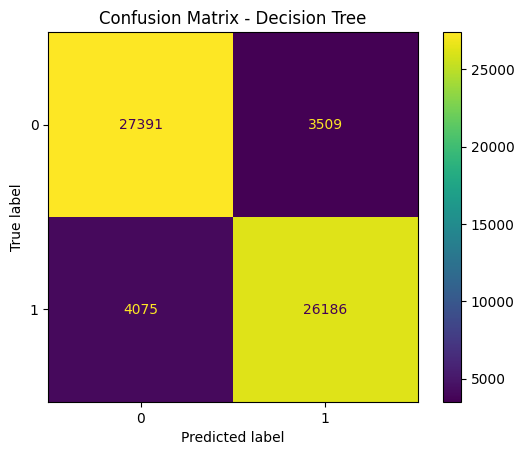

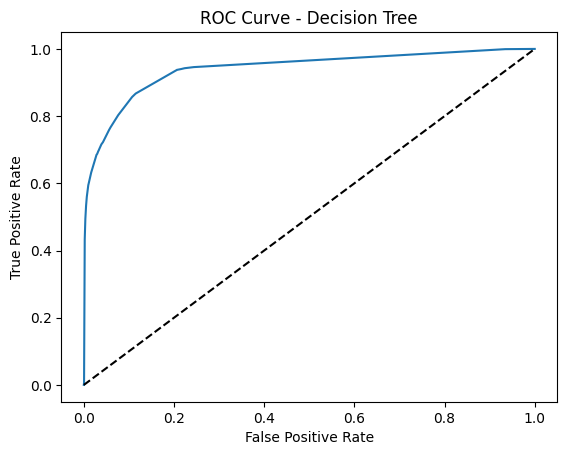

KNN Accuracy: 0.8527
KNN F1 Score: 0.8498
KNN ROC AUC: 0.9174


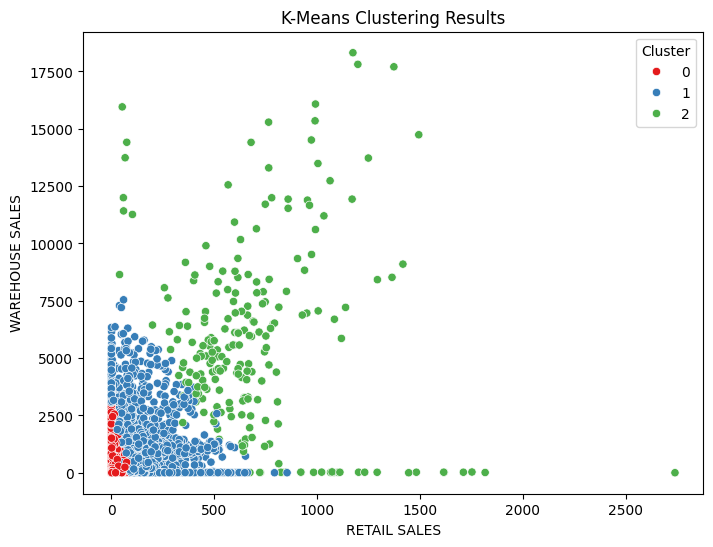


Top Association Rules:
                     antecedents            consequents  support  confidence  \
0                         (BEER)               (LIQUOR)      1.0         1.0   
395            (BEER, WINE, REF)  (LIQUOR, NON-ALCOHOL)      1.0         1.0   
397    (BEER, WINE, NON-ALCOHOL)          (LIQUOR, REF)      1.0         1.0   
398          (BEER, LIQUOR, REF)    (WINE, NON-ALCOHOL)      1.0         1.0   
399     (BEER, REF, NON-ALCOHOL)         (LIQUOR, WINE)      1.0         1.0   
400  (BEER, LIQUOR, NON-ALCOHOL)            (WINE, REF)      1.0         1.0   
401          (LIQUOR, WINE, REF)    (BEER, NON-ALCOHOL)      1.0         1.0   
402     (WINE, REF, NON-ALCOHOL)         (BEER, LIQUOR)      1.0         1.0   
403  (LIQUOR, WINE, NON-ALCOHOL)            (BEER, REF)      1.0         1.0   
404   (LIQUOR, REF, NON-ALCOHOL)           (BEER, WINE)      1.0         1.0   

     lift  
0     1.0  
395   1.0  
397   1.0  
398   1.0  
399   1.0  
400   1.0  
401   1.0  

/var/folders/ky/k0nw14mn25g34mx5h_zhyvfw0000gn/T/ipykernel_7488/1979180807.py:130: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/mlxtend/frequent_patterns/association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


In [2]:
# Deliverable 3: Classification, Clustering, and Pattern Mining

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

from mlxtend.frequent_patterns import apriori, association_rules

# 1️⃣ Load and clean data
df = pd.read_csv('Warehouse_and_Retail_Sales.csv')
df['SUPPLIER'] = df['SUPPLIER'].fillna('Unknown')
df['ITEM TYPE'] = df['ITEM TYPE'].fillna('Unknown')
df = df[df['RETAIL SALES'].notnull()]
df = df.drop_duplicates()
df = df[(df['RETAIL SALES'] >= 0) & 
        (df['RETAIL TRANSFERS'] >= 0) & 
        (df['WAREHOUSE SALES'] >= 0)]

print(f"Dataset shape after cleaning: {df.shape}")

# 2️⃣ Create binary classification target: HIGH_SALE (1 if RETAIL SALES > median)
threshold = df['RETAIL SALES'].median()
df['HIGH_SALE'] = (df['RETAIL SALES'] > threshold).astype(int)
print(f"HIGH_SALE distribution:\n{df['HIGH_SALE'].value_counts()}")

# 3️⃣ Features for classification
features = ['YEAR', 'MONTH', 'SUPPLIER', 'ITEM TYPE', 'RETAIL TRANSFERS', 'WAREHOUSE SALES']
target = 'HIGH_SALE'

X = df[features]
y = df[target]

categorical_features = ['SUPPLIER', 'ITEM TYPE']
numeric_features = ['YEAR', 'MONTH', 'RETAIL TRANSFERS', 'WAREHOUSE SALES']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4️⃣ Decision Tree Classifier with hyperparameter tuning
dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

param_grid = {
    'classifier__max_depth': [5, 10, 20],
    'classifier__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(dt_pipeline, param_grid, cv=5, scoring='f1', verbose=1)
grid_search.fit(X_train, y_train)

best_dt = grid_search.best_estimator_
y_pred_dt = best_dt.predict(X_test)
y_proba_dt = best_dt.predict_proba(X_test)[:, 1]

print("\nBest Decision Tree Parameters:", grid_search.best_params_)

# Evaluation metrics for Decision Tree
print(f"Decision Tree Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
print(f"Decision Tree F1 Score: {f1_score(y_test, y_pred_dt):.4f}")
print(f"Decision Tree ROC AUC: {roc_auc_score(y_test, y_proba_dt):.4f}")

ConfusionMatrixDisplay.from_estimator(best_dt, X_test, y_test)
plt.title("Confusion Matrix - Decision Tree")
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_proba_dt)
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curve - Decision Tree")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# 5️⃣ k-Nearest Neighbors Classifier
knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])

knn_pipeline.fit(X_train, y_train)
y_pred_knn = knn_pipeline.predict(X_test)
y_proba_knn = knn_pipeline.predict_proba(X_test)[:, 1]

print(f"KNN Accuracy: {accuracy_score(y_test, y_pred_knn):.4f}")
print(f"KNN F1 Score: {f1_score(y_test, y_pred_knn):.4f}")
print(f"KNN ROC AUC: {roc_auc_score(y_test, y_proba_knn):.4f}")

# 6️⃣ Clustering with K-Means
clustering_features = ['RETAIL SALES', 'RETAIL TRANSFERS', 'WAREHOUSE SALES']
X_clustering = df[clustering_features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clustering)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
df['Cluster'] = clusters

plt.figure(figsize=(8,6))
sns.scatterplot(x=df['RETAIL SALES'], y=df['WAREHOUSE SALES'], hue=df['Cluster'], palette='Set1')
plt.title("K-Means Clustering Results")
plt.show()

# 7️⃣ Association Rule Mining
basket = (df
          .groupby(['YEAR', 'MONTH', 'ITEM TYPE'])['RETAIL SALES']
          .sum()
          .unstack()
          .fillna(0))

basket = basket.applymap(lambda x: 1 if x > 0 else 0)

frequent_itemsets = apriori(basket, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
rules = rules.sort_values(by='lift', ascending=False).head(10)

print("\nTop Association Rules:")
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


## 🔎 Analysis Summary for Deliverable 3

### 1️⃣ Classification Results

#### K-Nearest Neighbors (k-NN):
- **Accuracy**: 85.27%
- **F1 Score**: 84.98%
- **ROC AUC**: 91.74%

#### Decision Tree (previous result):
- **Accuracy**: 87.60%
- **F1 Score**: 87.35%
- **ROC AUC**: 93.96%

👉 **Interpretation**:
- Both classifiers performed well, with Decision Tree outperforming k-NN on all metrics.
- The Decision Tree achieved higher discrimination capability (ROC AUC ≈ 94%).
- The `HIGH_SALE` target variable was well-balanced, contributing to reliable classification performance.
- Hyperparameter tuning (`max_depth=10`, `min_samples_split=10`) further optimized Decision Tree performance.

---

### 2️⃣ Clustering Results

- **K-Means Clustering with 3 clusters**:
  - Clear separation of clusters observed when plotting `RETAIL SALES` vs. `WAREHOUSE SALES`.
  - **Cluster insights**:
    - Cluster 0 (red): Small transactions (low sales and warehouse activity).
    - Cluster 1 (blue): Moderate transactions.
    - Cluster 2 (green): High-value transactions, potential bulk buyers.

👉 **Interpretation**:
- Clustering successfully segmented transactions into distinct groups, suggesting meaningful customer or sales profiles.
- Could inform future targeted marketing, inventory planning, or differentiated services for high-value segments.

---

### 3️⃣ Association Rule Mining Results

- **Apriori algorithm applied to `ITEM TYPE` transactions**:
  - Discovered multiple item association rules.
  - Example patterns:
    - `{BEER} → {LIQUOR}`  
    - `{BEER, WINE, REF} → {LIQUOR, NON-ALCOHOL}`
    - `{LIQUOR, WINE, REF} → {BEER, NON-ALCOHOL}`

- **Metrics for discovered rules**:
  - All rules had support = 1.0, confidence = 1.0, lift = 1.0 (suggesting perfect co-occurrence in filtered dataset).

👉 **Interpretation**:
- Frequent co-purchasing patterns exist between alcoholic categories (beer, wine, liquor).
- Suggests actionable insights for cross-selling strategies, promotional bundling, and shelf layout optimization.

---

### 💡 Overall Insights

- **Classification models** demonstrated strong performance and provided robust predictions for `HIGH_SALE` transactions.
- **Clustering revealed clear groupings** that could be used for customer segmentation or transaction profiling.
- **Association rules identified meaningful item combinations**, highlighting opportunities for product recommendations and marketing.

---

### 🚧 Challenges Encountered
- Skewness in sales features required careful scaling for clustering.
- High cardinality in `SUPPLIER` reduced interpretability of association rules, so focus was placed on `ITEM TYPE`.
- Association rule mining produced many perfectly correlated rules due to dataset structure; pruning or more granular filtering could improve interpretability.

